# Fast AutoCV - Experimento

Este componente utiliza o três arquiteturas presentes na biblioteca [PyTorch](https://pytorch.org/) para a tarefa de classificação de imagens. São elas: ResNet-18, ResNet-50 e VGG16.    
Cada uma das arquiteturas é treinada aplicando-se no conjunto de treino e validação um dos 3 conjuntos de polices genéricas definidas pelo artigo [Fast AutoAugment](https://arxiv.org/pdf/1905.00397.pdf), sujo código está disponibilizado no [GitHub](https://github.com/kakaobrain/fast-autoaugment).

Ao final, o modelo de maior acurácia no conjunto de validação para o dataset utilizado será salvo para futura utilização.
#### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
O parâmetro `dataset` identifica os conjuntos de dados. Você pode importar arquivos de dataset com o botão  na barra de ferramentas.

Para esse componente, a base de dados deve estar no seguinte formado:
- Arquivo CSV chamado dataset.csv contendo as colunas "image_path", "target" e "subset", onde:
    - image_path: caminho para o arquivo de imagem.
    - target: resposta esperada da predição, caso exista.
    - subset: conjunto ao qual a amostra faz parte, pode ser "train", "test", e "val". 
- Imagens coloridas (3 canais) no formato 224x224 pixels. Caso não estejam nesse formato, o código faz as alterações necesssárias
- Cada classe tem sua pasta com suas respectivas imagens, além dos conjuntos de treino, validação e teste terem suas pastas separadas. Um exemplo da árvore de diretórios pode ser observado abaixo:

```bash
dataset
|________dataset.csv
|________train
|        |_____class_name1
|        |     |____image0.jpg
|        |     |____image1.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image3.jpg
|              |____image4.jpg
|               ...
|
|________val
|        |_____class_name1
|        |     |____image5.jpg
|        |     |____image6.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image7.jpg
|              |____image8.jpg
|               ...
|
|________test
|        |_____class_name1
|        |     |____image9.jpg
|        |     |____image10.jpg
|        |     ...
|        |
|        |_____class_name2
|              |____image11.jpg
|              |____image12.jpg
|              ...
```

In [1]:
dataset = "/tmp/data/hymenoptera.zip" #@param {type:"string"}

arch_list = ["resnet18", "resnet50", "vgg16"] #@param ["resnet18", "resnet50", "vgg16"]{type:"string", multiple: true, label:"Arquiteturas disponíveis para escolha.", description: "Inserir o nome das arquiteturas que deseja utilizar na busca em forma de lista."}
aug_polices = ["fa_reduced_cifar10", "fa_resnet50_rimagenet", "fa_reduced_svhn"] #@param ["fa_reduced_cifar10", "fa_resnet50_rimagenet", "fa_reduced_svhn"]{type: "string", multiple: true, label: "Conjuntos de polices disponíveis.", description: "Inserir o nome dos conjuntos de polices que deseja utilizar na busca em forma de lista."}
# Quantas predições queremos.
# Deve ser menor ou igual ao número de classes
top_predictions = 1 #@param {type:"integer", label: "Quantidade de predições desejadas", description: "Define quantas predições se quer ter de resposta para uma predição realizada pela rede. Valor máximo é igual ao número total de classes."}

# variáveis utilizadas na etapa de treinamento do modelo
batch = 8 #@param {type:"integer", label: "Tamanho do batch", description: "Número de amostras utilizadas em cada batch"}
epochs = 1 #@param {type:"integer", label: "Número de épocas", description: "Quantidade de épocas que cada arquitetura será treinada."}
lr = 0.001 #@param {type:"float", label: "Learning rate", description: "Valor do learning rate utilizado no treinamento"}
gamma = 0.1 #@param {type:"float", label: "Gamma", description: "Valor de gamma utilizado na descida do gradiente"}
step_size = 7 #@param {type:"integer", label: "Tamanho do passo", description: "Tamanho do passo utilizado na descida do gradiente"}
momentum = 0.1 #@param {type:"float", label: "Momentum", description: "Valor do momentum utilizado na descida do gradiente"}

In [2]:
# Variáveis globais. Evite modificá-las.
ARCH_LIST = ['resnet18', 'resnet50', 'vgg16']
POLICES_LIST = ['fa_reduced_cifar10', 'fa_resnet50_rimagenet', 'fa_reduced_svhn']
CSV_FILENAME = "/tmp/data/best_models_acc.csv"
checkpoint_path = "/tmp/data/models-output/" # Caminho para salvar os checkpoints dos modelos treinados
output_graphs = "/tmp/data/eval-images/" # Caminha para salvar as imagens dos gráficos de loss e acurácia relativos aos treinamentos

In [ ]:
# MLFlow is used for tracking of metrics, dependencies and artifacts

import mlflow

mlflow.start_run()

## Extração de dados do arquivo .zip


In [3]:
import os
import zipfile

root_folder_name = dataset.split("/")[-1].split(".")[0]
root_folder = os.path.join("/tmp/data", root_folder_name)
with zipfile.ZipFile(dataset, 'r') as zip_ref:
   zip_ref.extractall(root_folder)

os.makedirs(checkpoint_path, exist_ok=True)
os.makedirs(output_graphs, exist_ok=True)
dataset_id = root_folder_name # Nome base para salvar os modelos

## Classificação de Images

In [4]:
# Funções auxiliares para imprimir as informações 
# dos modelos treinados e selecionar o melhor modelo

def save_to_csv(csv_path, arch, police, val_acc):
    """Save a csv file with best models infos"""
    data = {
        "dataset": [dataset_id],
        "architecture_id": [arch],
        "police_id": [police],
        "val_acc": [val_acc]}
    dataframe = pd.DataFrame(data)
    output_path = os.path.join(csv_path, CSV_FILENAME)
    if os.path.isfile(output_path):
        dataframe.to_csv(output_path, mode="a", header=False, index=False)
    else:
        dataframe.to_csv(output_path, index=False)

def best_models_stats(csv):
    """Print best model and all trained models"""
    dataframe = pd.read_csv(csv)
    dataframe.sort_values(by=["val_acc"], inplace=True, ascending=False)
    dataframe.reset_index(drop=True, inplace=True)
    best_cases = dataframe.loc[dataframe['dataset'] == dataset_id].head()
    print("### TOP 5 BEST MODELS ON {0} DATASET ###\n".format(dataset_id))
    print(best_cases, "\n")
    print("### ALL MODELS TRAINED ON {0} DATASET ### \n".format(dataset_id))
    print(dataframe.loc[dataframe['dataset'] == dataset_id], "\n")
    
    best_model = best_cases.iloc[0]
    return best_model

In [5]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler

from data import LoadData
from finetuning import FineTuning
from visualizations import ImageVisualization
from checkpoint import Checkpoint
from models import Model, ModelInfos

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, type(device))

multi_gpu = False
if cuda.is_available():
    gpu_count = cuda.device_count()
    print(gpu_count, ' gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
l_data = LoadData(root_folder)
checkpoint = Checkpoint(dataset_id, multi_gpu, checkpoint_path)
criterion = nn.CrossEntropyLoss()

n_classes = len(os.listdir(os.path.join(root_folder, "train")))
model_ft = FineTuning(arch_list, n_classes)

cpu <class 'torch.device'>


### 1. Treinamento dos modelos

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16-397923af.pth




######
Model architecture: resnet18
Police: fa_reduced_cifar10
Start to training a model.
Epoch 1/1



/home/jovyan/tasks/Fast AutoCV/networks.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


train Loss: 0.7334 Acc: 0.4877
val Loss: 0.6690 Acc: 0.6471
Training completed in 4m 8s
Best val Acc: 0.6471


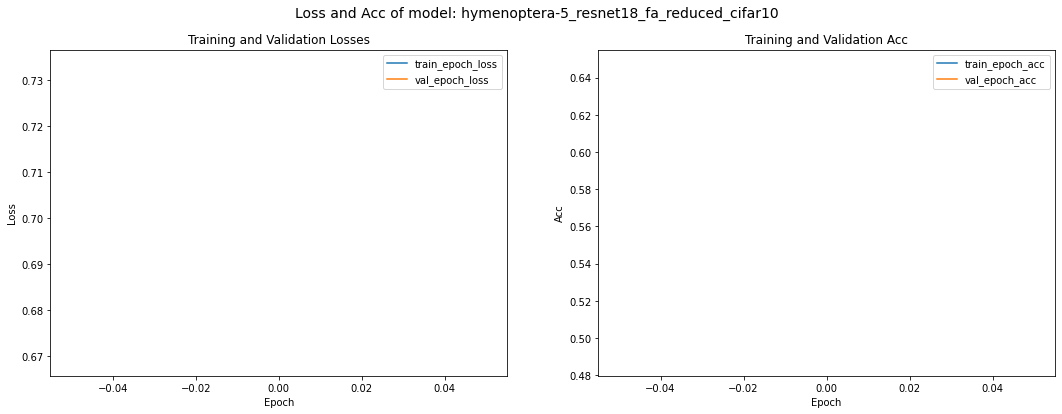

In [6]:
for police in aug_polices:
    assert (police in POLICES_LIST), 'police not found'
    dataloaders, dataset_sizes, class_names = l_data.load_data_train(police)
    visual = ImageVisualization(device, dataloaders, output_graphs)
    for arch in arch_list:
        assert (arch in ARCH_LIST), 'archictecture not supported'
        model_train = Model(arch, device, checkpoint)
        model_name = "{0}_{1}_{2}".format(dataset_id, arch, police)
        model_path = os.path.join(checkpoint_path, model_name)

        if not os.path.exists(model_path):
            model_conv = model_ft.fine_tuning(arch)
            optimizer_conv = optim.SGD(
                model_conv.parameters(),
                lr=lr, momentum=momentum)
            exp_lr_scheduler = lr_scheduler.StepLR(
                optimizer_conv, step_size=step_size, gamma=gamma)
            model_conv, best_model_val_acc = model_train.train_model(
                model_conv, police, dataloaders, dataset_sizes, criterion,
                optimizer_conv, exp_lr_scheduler, num_epochs=epochs)
            save_to_csv(checkpoint_path, arch, police, best_model_val_acc)
            visual.visualize_results(model_conv.history, dataset_id + '_' + arch + '_' + police)

        elif os.path.exists(model_path):
            model_checkpoint = checkpoint.load_checkpoint(
                arch,
                checkpoint_path + dataset_id + '_' + arch + '_' + police)
            exp_lr_scheduler = lr_scheduler.StepLR(
                model_checkpoint.optimizer, step_size=step_size,
                gamma=gamma)
            model_checkpoint, best_model_val_acc = model_train.train_model(
                model_checkpoint, police, dataloaders,dataset_sizes, criterion,
                model_checkpoint.optimizer, exp_lr_scheduler, num_epochs=epochs)
            save_to_csv(checkpoint_path, arch, police, best_model_val_acc)

In [7]:
best_model = best_models_stats(os.path.join(checkpoint_path, CSV_FILENAME))
best_model_name = "{0}_{1}_{2}".format(best_model['dataset'], best_model['architecture_id'], best_model['police_id'])
best_model_path = os.path.join(checkpoint_path, best_model_name)

### TOP 5 BEST MODELS ON hymenoptera-5 DATASET ###

         dataset architecture_id           police_id   val_acc
0  hymenoptera-5        resnet18  fa_reduced_cifar10  0.647059 

### ALL MODELS TRAINED ON hymenoptera-5 DATASET ### 

         dataset architecture_id           police_id   val_acc
0  hymenoptera-5        resnet18  fa_reduced_cifar10  0.647059 



### 2. Teste do melhor modelo

In [8]:
model_path = best_model_path
dataloaders, dataset_sizes, class_names = l_data.load_data_test()

# Run inference for test set
model = Model(best_model['architecture_id'], device)
acc_per_class, confusion_mtx, report = model.predict_batch(
    multi_gpu,
    model_path,
    dataloaders,
    dataset_sizes,
    class_names)

print("Acurácia por classe:")
for i, name in enumerate(class_names):
    print("Class: {0} -> Acc: {1}".format(class_names[i], acc_per_class[i]))


['ants', 'bees'] {'test': 15}
11,308,354 total parameters.
131,842 total gradient parameters.


/home/jovyan/tasks/Fast AutoCV/networks.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


Acurácia por classe:
Class: ants -> Acc: 0.0
Class: bees -> Acc: 0.875


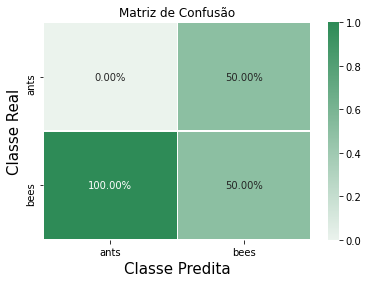

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ticklabels = class_names
ax = plt.axes()
sns.heatmap((confusion_mtx/sum(confusion_mtx)), annot=True,
            xticklabels=ticklabels, yticklabels=ticklabels,
            fmt='.02%',
            cmap=sns.light_palette("seagreen", as_cmap=True),
            linewidths=0.2, ax = ax)

ax.set_title('Matriz de Confusão')
plt.xlabel('Classe Predita', fontsize = 15)
plt.ylabel('Classe Real', fontsize = 15)
plt.show()

In [10]:
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
ants,0.000000,0.000000,0.000000,7.000000
bees,0.500000,0.875000,0.636364,8.000000
accuracy,0.466667,0.466667,0.466667,0.466667
macro avg,0.250000,0.437500,0.318182,15.000000
weighted avg,0.266667,0.466667,0.339394,15.000000


## Salva métricas
Utiliza a função `log_metric` do [SDK do MLflow](https://www.mlflow.org/docs/latest/tracking.html#performance-tracking-with-metrics) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [11]:
# from platiagro import save_metrics
import pandas as pd

data = {'class': [class_names[0], class_names[1]],
        'accuracy': [acc_per_class[0], acc_per_class[1]]
       }
df_acc = pd.DataFrame(data)
df_acc


mlflow.log_metric("classification_report", report_df)
mlflow.log_metric("accuracy_per_class", df_acc)


## Salva modelo e outros resultados do treinamento

Escreve todos artefatos na pasta `/tmp/data/`. A plataforma guarda os artefatos desta pasta para usos futuros como implantação e comparação de resultados.

In [12]:
from joblib import dump

artifacts = {
    "model_arch": best_model['architecture_id'],
    "dataset": best_model['dataset'], 
    "model_police": best_model['police_id'],
    "model_name": best_model_name,
    "model_path": best_model_path,
    "class_names": class_names
}
dump(artifacts, '/tmp/data/model.joblib')

['/tmp/data/model.joblib']